# Tutorial Part ??: Training a Normalizing Flow on QM9
By [Nathan C. Frey](https://ncfrey.github.io/) | [Twitter](https://twitter.com/nc_frey)


In this tutorial, we will train a Normalizing Flow (NF) on the [QM9 dataset](https://www.nature.com/articles/sdata201422). The dataset comprises 133,885 stable small organic molecules made up of CHNOF atoms. We will try to train a network that is an invertible transformation between a simple base distribution and the distribution of molecules in QM9.  One of the key advantages of normalizing flows is that they can be constructed to efficiently sample from a distribution (generative modeling) and do probability density calculations (exactly compute log-likelihoods), whereas other models make tradeoffs between the two or can only approximate probability densities.

NFs are useful whenever we need a probabilistic model with one or both of these capabilities. Note that because NFs are completely invertible, there is no "latent space" in the sense used when referring to generative adversarial networks or variational autoencoders. For more on NFs, we refer to this [review paper](https://arxiv.org/pdf/1912.02762.pdf).


To encode the QM9 dataset, we'll make use of the SELFIES (SELF-referencIng Embedded Strings) representation, which is a 100% robust molecular string representation. SMILES strings produced by generative models are often syntactically invalid (they do not correspond to a molecular graph), or they violate chemical rules like the maximum number of bonds between atoms. SELFIES are designed so that even totally random SELFIES strings correspond to valid molecular graphs, so they are a great framework for generative modeling. For more details about SELFIES, see the [GitHub repo](https://github.com/aspuru-guzik-group/selfies) and the associated [paper](https://arxiv.org/abs/1905.13741).


## Colab

This tutorial and the rest in this sequence are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/23_Training_a_Normalizing_Flow_on_QM9.ipynb)

## Setup

To run DeepChem within Colab, you'll need to run the following cell of installation commands. This will take about 5 minutes to run to completion and install your environment.

In [1]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3490  100  3490    0     0  15863      0 --:--:-- --:--:-- --:--:-- 15863


add /root/miniconda/lib/python3.6/site-packages to PYTHONPATH
python version: 3.6.9
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit, openmm, pdbfixer
added conda-forge to channels
added omnia to channels
done
conda packages installation finished!


# conda environments:
#
base                  *  /root/miniconda



In [2]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

     |████████████████████████████████| 399kB 2.6MB/s 
  Created wheel for deepchem: filename=deepchem-2.4.0rc1.dev20200924184214-cp36-none-any.whl size=499031 sha256=bb06a3dd7f6e432a05d18f54403bc00e292ddc9c52b8d5008c640c3153b917ee
  Stored in directory: /root/.cache/pip/wheels/c7/5c/0b/1f5cfa9461cf4af4190b45b7ae87ecc22ee5bdfb55748cfbe3
Successfully built deepchem


'2.4.0-rc1.dev'

Install the SELFIES library to translate SMILES strings.

In [3]:
!git clone https://github.com/aspuru-guzik-group/selfies.git
%cd selfies
!pip install .
%cd ..

Cloning into 'selfies'...
remote: Enumerating objects: 157, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 2026 (delta 90), reused 85 (delta 43), pack-reused 1869
Receiving objects: 100% (2026/2026), 12.38 MiB | 17.27 MiB/s, done.
Resolving deltas: 100% (1276/1276), done.
/content/selfies
Processing /content/selfies
  Created wheel for selfies: filename=selfies-1.0.1-cp36-none-any.whl size=27081 sha256=7c0b9aa7277c7a1103b657efc0354829b65851f2b2fa8e2082ae31544350be83
  Stored in directory: /tmp/pip-ephem-wheel-cache-lkv5aj3a/wheels/d0/8b/6e/8a44d44da67fdb190acc4f94129ff1428fc623ff9ad9a7abed
Successfully built selfies
/content


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

import deepchem as dc
from deepchem.models.normalizing_flows import NormalizingFlow, NormalizingFlowModel
from deepchem.models.optimizers import Adam
from deepchem.data import NumpyDataset
from deepchem.splits import RandomSplitter
from deepchem.molnet import load_tox21

import rdkit
from rdkit.Chem import Draw

from IPython.display import Image, display

import selfies as sf

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors
tfk = tf.keras

tfk.backend.set_floatx('float64')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


First, let's get a dataset of 2500 small organic molecules from the QM9 dataset. We'll then convert the molecules to SELFIES, one-hot encode them, and dequantize the inputs so they can be processed by a normalizing flow. 2000 molecules will be used for training, while the remaining 500 will be split into validation and test sets. We'll use the validation set to see how our architecture is doing at learning the underlying the distribution, and leave the test set alone. You should feel free to experiment with this notebook to get the best model you can and evaluate it on the test set when you're done!

In [6]:
# Download from MolNet
tasks, datasets, transformers = dc.molnet.load_qm9(featurizer='ECFP')
df = pd.DataFrame(data={'smiles': datasets[0].ids})

In [7]:
data = df[['smiles']].sample(2500, random_state=42)

SELFIES defines a dictionary called `bond_constraints` that enforces how many bonds every atom or ion can make. E.g., 'C': 4, 'H': 1, etc. The `?` symbol is used for any atom or ion that isn't defined in the dictionary, and it defaults to 8 bonds. Because QM9 contains ions and we don't want to allow those ions to form up to 8 bonds, we'll constrain them to 3. This will really improve the percentage of valid molecules we generate. You can read more about setting constraints in the [SELFIES documentation](https://selfies-mirror.readthedocs.io/en/latest/selfies_examples.html#Advanced-Usage).

In [8]:
sf.set_semantic_constraints()  # reset constraints
constraints = sf.get_semantic_constraints()
constraints['?'] = 3

sf.set_semantic_constraints(constraints)
constraints

{'?': 3,
 'Br': 1,
 'C': 4,
 'Cl': 1,
 'F': 1,
 'H': 1,
 'I': 1,
 'N': 3,
 'O': 2,
 'P': 5,
 'S': 6}

In [9]:
def preprocess_smiles(smiles):
  return sf.encoder(smiles)  

data['selfies'] = data['smiles'].apply(preprocess_smiles)

Let's take a look at some short SMILES strings and their corresponding SELFIES representations. We can see right away that there is a key difference in how the two representations deal with Rings and Branches. SELFIES is designed so that branch length and ring size are stored locally with the `Branch` and `Ring` identifiers, and the SELFIES grammar prevents invalid strings.

In [10]:
data['len'] = data['smiles'].apply(lambda x: len(x))
data.sort_values(by='len').head()

,smiles,selfies,len
70607,CCCC=O,[C][C][C][C][=O],6
99883,CCOCCOC,[C][C][O][C][C][O][C],7
37561,c1nnon1,[C][N][=N][O][N][Expl=Ring1][Branch1_1],7
73796,COCCCCO,[C][O][C][C][C][C][O],7
92088,CC#CCCCO,[C][C][#C][C][C][C][O],8


To convert SELFIES to a one-hot encoded representation, we need to construct an `alphabet` of all the characters that occur in the list of SELFIES strings. We also have to know what the longest SELFIES string is, so that all the shorter SELFIES can be padded with `'[nop]'` to be equal length.

In [11]:
selfies_list = np.asanyarray(data.selfies)
selfies_alphabet = sf.get_alphabet_from_selfies(selfies_list)
selfies_alphabet.add('[nop]')  # Add the "no operation" symbol as a padding character
selfies_alphabet = list(sorted(selfies_alphabet))
largest_selfie_len = max(sf.len_selfies(s) for s in selfies_list)

`selfies` has a handy utility function to translate SELFIES strings into one-hot encoded vectors.

In [12]:
onehots = sf.multiple_selfies_to_hot(selfies_list, largest_selfie_len, selfies_alphabet)

Next, we "dequantize" the inputs by adding random noise from the interval `[0, 1)` to every input in the encodings. This allows the normalizing flow to operate on continuous inputs (rather than discrete), and the original inputs can easily be recovered by applying a floor function.

In [13]:
input_tensor = tf.convert_to_tensor(onehots, dtype='float64')
noise_tensor = tf.random.uniform(shape=input_tensor.shape, minval=0, maxval=1, dtype='float64')
dequantized_data = tf.add(input_tensor, noise_tensor)

The dequantized data is ready to be processed as a DeepChem dataset and split into training, validation, and test sets. We'll also keep track of the SMILES strings for the training set so we can compare the training data to our generated molecules later on.

In [14]:
ds = NumpyDataset(dequantized_data)  # Create a DeepChem dataset
splitter = RandomSplitter()
train, val, test = splitter.train_valid_test_split(dataset=ds, seed=42)
train_idx, val_idx, test_idx = splitter.split(dataset=ds, seed=42)

dim = len(train.X[0])  # length of one-hot encoded vectors
train.X.shape  # 2000 samples, N-dimensional one-hot vectors that represent molecules

(2000, 588)

In [15]:
# SMILES strings of training data
train_smiles = data['smiles'].iloc[train_idx].values

Next we'll set up the normalizing flow model. The base distribution is a multivariate Normal distribution. The `permutation` layer permutes the dimensions of the input so that the normalizing flow layers will operate along multiple dimensions of the inputs. To understand why the permutation is needed, we need to know a bit about how the normalizing flow architecture works.

In [16]:
base_dist = tfd.MultivariateNormalDiag(loc=np.zeros(dim), scale_diag=np.ones(dim))

if dim % 2 == 0:
    permutation = tf.cast(np.concatenate((np.arange(dim / 2, dim), np.arange(0, dim / 2))),
                                  tf.int32)
else:
    permutation = tf.cast(np.concatenate((np.arange(dim / 2 + 1, dim), np.arange(0, dim / 2))), tf.int32)

For this simple example, we'll set up a flow of repeating [Masked Autoregressive Flow](https://arxiv.org/abs/1705.07057) layers. The autoregressive property is enforced by using the [Masked Autoencoder for Distribution Estimation](https://arxiv.org/abs/1502.03509) architecture. The layers of the flow are a bijector, an invertible mapping between the base and target distributions.

MAF takes the inputs from the base distribution and transforms them with a simple scale-and-shift (affine) operation, but crucially the scale-and-shift for each dimension of the output *depends on the previously generated dimensions of the output.* That independence of future dimensions preserves the *autoregressive* property and ensures that the normalizing flow is invertible. Now we can see that we need permutations to change the ordering of the inputs, or else the normalizing flow would only transform certain dimensions of the inputs.

Batch Normalization layers can be added for additional stability in training, but may have strange effects on the outputs and require some input reshaping to work properly. Increasing `num_layers` and `hidden_units` can make more expressive flows capable of modeling more complex target distributions.

In [17]:
num_layers = 8
flow_layers = []

Made = tfb.AutoregressiveNetwork(params=2,
                                 hidden_units=[512, 512], activation='relu')

for i in range(num_layers):
    flow_layers.append(        
        (tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=Made)
    ))

    permutation = tf.cast(np.random.permutation(np.arange(0, dim)), tf.int32)
    
    flow_layers.append(tfb.Permute(permutation=permutation))
    
#     if (i + 1) % int(2) == 0:
#         flow_layers.append(tfb.BatchNormalization())

We can draw samples from the untrained distribution, but for now they don't have any relation to the QM9 dataset distribution.

In [18]:
%%time
nf = NormalizingFlow(base_distribution=base_dist,
                    flow_layers=flow_layers)
samples = nf.flow.sample(5)

CPU times: user 45.7 s, sys: 1.77 s, total: 47.5 s
Wall time: 35.5 s


A `NormalizingFlowModel` takes a `NormalizingFlow` and any parameters used by `deepchem.models.KerasModel`.

In [19]:
nfm = NormalizingFlowModel(nf, learning_rate=1e-4, batch_size=128)

Now to train the model! We'll try to minimize the negative log likelihood loss, which measures the likelihood that generated samples are drawn from the target distribution, i.e. as we train the model, it should get better at modeling the target distribution and it will generate samples that look like molecules from the QM9 dataset. 

In [20]:
losses = []
val_losses = []

In [21]:
%%time
max_epochs = 20 # maximum number of epochs of the training

for epoch in range(max_epochs):
  loss = nfm.fit(train, nb_epoch=1, all_losses=losses)
  val_loss = nfm.create_nll(val.X)
  val_losses.append(val_loss.numpy())

CPU times: user 7min 9s, sys: 9.26 s, total: 7min 18s
Wall time: 3min 48s


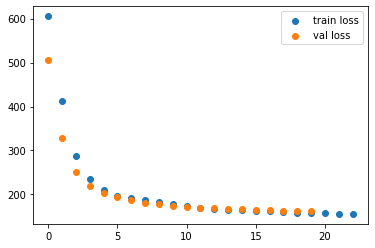

In [22]:
f, ax = plt.subplots()
ax.scatter(range(len(losses)), losses, label='train loss')
ax.scatter(range(len(val_losses)), val_losses, label='val loss')
plt.legend(loc='upper right');

The normalizing flow is learning a mapping between the multivariate Gaussian and the target distribution! We can see this by visualizing the loss on the validation set. We can now use `nfm.flow.sample()` to generate new QM9-like molecules and `nfm.flow.log_prob()` to evaluate the likelihood that a molecule was drawn from the underlying distribution.

In [23]:
generated_samples = nfm.flow.sample(50)  # generative modeling
log_probs = nfm.flow.log_prob(generated_samples)  # probability density estimation

Now we transform the generated samples back into SELFIES. We have to quantize the outputs and add padding characters to any one-hot encoding vector that has all zeros.

In [24]:
mols = tf.math.floor(generated_samples)  # quantize data
mols = tf.clip_by_value(mols, 0, 1)  # Set negative values to 0 and values > 1 to 1
mols_list = mols.numpy().tolist()

# Add padding characters if needed
for mol in mols_list:
  for i in range(largest_selfie_len):
    row = mol[len(selfies_alphabet) * i: len(selfies_alphabet) * (i + 1)]
    if all(elem == 0 for elem in row):
      mol[len(selfies_alphabet) * (i+1) - 1] = 1

`selfies` has another utility function to translate one-hot encoded representations back to SELFIES strings.

In [25]:
mols = sf.multiple_hot_to_selfies(mols_list, largest_selfie_len, selfies_alphabet)

We can use RDKit to find valid generated molecules. Some have unphysical valencies and should be discarded. If you've ever tried to generate valid SMILES strings, you'll notice right away that this model is doing much better than we would expect! Using SELFIES, 90\% of the generated molecules are valid, even though our normalizing flow architecture doesn't know any rules that govern chemical validity.

In [26]:
from rdkit import RDLogger  
from rdkit import Chem
RDLogger.DisableLog('rdApp.*')  # suppress error messages

valid_count = 0
valid_selfies, invalid_selfies = [], []
for idx, selfies in enumerate(mols):
  try:
    if Chem.MolFromSmiles(sf.decoder(mols[idx]), sanitize=True) is not None:
        valid_count += 1
        valid_selfies.append(selfies)
    else:
      invalid_selfies.append(selfies)
  except Exception:
    pass
print('%.2f' % (valid_count / len(mols)),  '% of generated samples are valid molecules.')

0.90 % of generated samples are valid molecules.


Let's take a look at some of the generated molecules! We'll borrow some helper functions from the [Modeling Solubility](https://github.com/deepchem/deepchem/blob/master/examples/tutorials/03_Modeling_Solubility.ipynb) tutorial to display molecules with RDKit.

In [29]:
gen_mols = [Chem.MolFromSmiles(sf.decoder(vs)) for vs in valid_selfies]

In [30]:
def display_images(filenames):
    """Helper to pretty-print images."""
    for file in filenames:
      display(Image(file))

def mols_to_pngs(mols, basename="generated_mol"):
    """Helper to write RDKit mols to png files."""
    filenames = []
    for i, mol in enumerate(mols):
        filename = "%s%d.png" % (basename, i)
        Draw.MolToFile(mol, filename)
        filenames.append(filename)
    return filenames

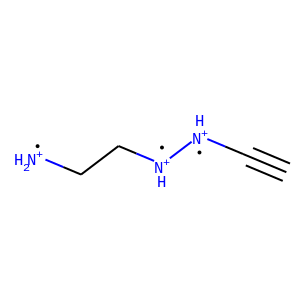

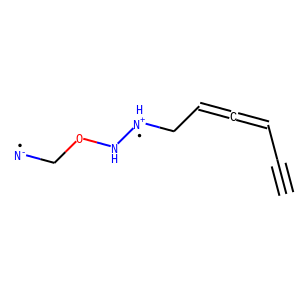

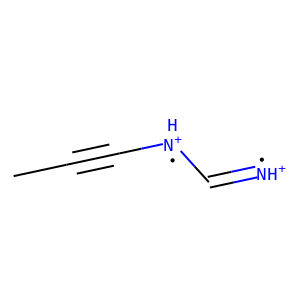

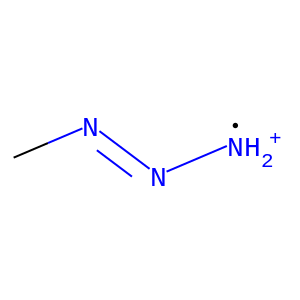

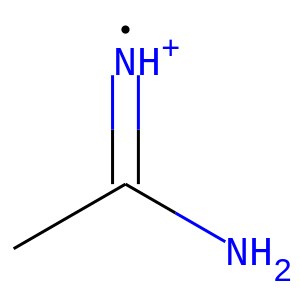

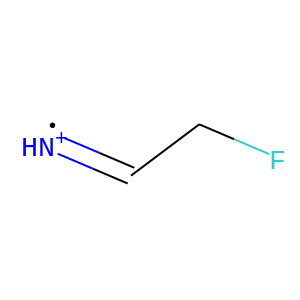

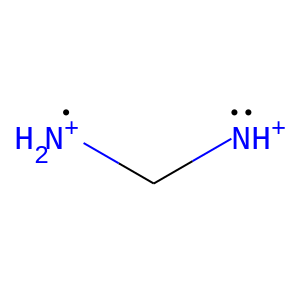

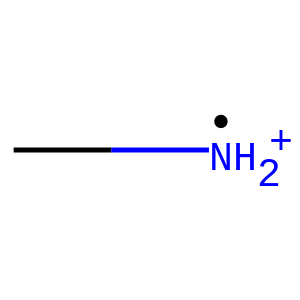

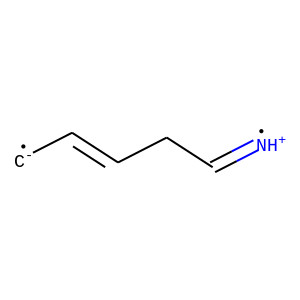

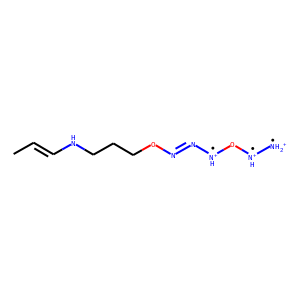

In [31]:
display_mols = []
for i in range(10):
  display_mols.append(gen_mols[i])

display_images(mols_to_pngs(display_mols))

Finally, we can compare generated molecules with our training data via a [similarity search](https://medium.com/gsi-technology/rdkit-for-newbies-3697e617521f) with Tanimoto similarity. This gives an indication of how "original" the generated samples are, versus simply producing samples that are extremely similar to molecules the model has already seen. We have to keep in mind that QM9 contains *all* stable small molecules with up to 9 heavy atoms (CONF). So anything new we generate either exists in the full QM9 dataset, or else will not obey the charge neutrality and stability criteria used to generated QM9.

In [32]:
from rdkit.Chem.Fingerprints.FingerprintMols import FingerprintMol
from rdkit.DataStructs import FingerprintSimilarity
from IPython.display import display

def tanimoto_similarity(database_mols, query_mol):
    """Compare generated molecules to database by Tanimoto similarity."""
    # convert Mol to datastructure type
    fps = [FingerprintMol(m) for m in database_mols]
    
    # set a query molecule to compare against database
    query = FingerprintMol(query_mol)
    
    similarities = []
    
    # loop through to find Tanimoto similarity
    for idx, f in enumerate(fps):
        # tuple: (idx, similarity)
        similarities.append((idx, FingerprintSimilarity(query, f)))
    
    # sort sim using the similarities
    similarities.sort(key=lambda x:x[1], reverse=True)
    
    return similarities

We'll consider our generated molecules and look at the top 3 most similar molecules from the training data by Tanimoto similarity. Here's an example where the Tanimoto similarity scores are low! There are no molecules in our training set that are very similar to our generated sample. This might be interesting, or it might mean that the generated molecule is unrealistic.

In [33]:
train_mols = [Chem.MolFromSmiles(smiles) for smiles in train_smiles]

In [40]:
# change the second argument to compare different generated molecules to QM9
tanimoto_scores = tanimoto_similarity(train_mols, gen_mols[3])
similar_mols = []

0.243
0.243
0.241


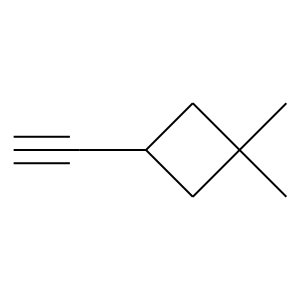

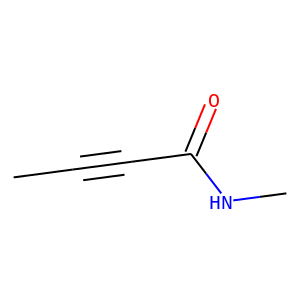

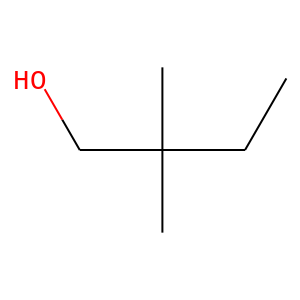

In [41]:
for idx, ts in tanimoto_scores[:3]:
    print(round(ts, 3))
    similar_mols.append(train_mols[idx])

display_images(mols_to_pngs(similar_mols, 'qm9_mol'))

### Further reading

So far we have looked at a measure of validity and done a bit of investigation into the novelty of the generated compounds. There are more dimensions along which we can and should evaluate the performance of a generative model. For an example of some standard benchmarks, see the [GuacaMol evaluation framework](https://arxiv.org/pdf/1811.09621.pdf).

For examples of normalizing flow-based molecular graph generation frameworks, check out the [MoFlow](https://arxiv.org/abs/2006.10137), [GraphAF](https://arxiv.org/pdf/2001.09382.pdf), and [GraphNVP](https://arxiv.org/pdf/1905.11600.pdf) papers.

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!